In [254]:
import numpy as np
import pandas as pd
import yaml
from matplotlib import pyplot as plt
import os

experiment_folder = '/home/joseph/workspaces/hsa_hopper/hsa_hopper_control/data/hsa_wood_1300g/2024-05-15_1715812056'
# experiment_folder = '/home/joseph/workspaces/hsa_hopper/hsa_hopper_control/data/no_hsa_wood_1300g/2024-05-15_1715733932'
with open(os.path.join(experiment_folder, 'experiment_config.yaml'), 'r') as f:
    experiment_config = yaml.load(f,yaml.Loader)
with open(os.path.join(experiment_folder, 'hardware_config.yaml'), 'r') as f:
    hardware_config = yaml.load(f,yaml.Loader)

# read tabular data
hop_files_relpath = [relpath for relpath in os.listdir(experiment_folder) if 'hop' in relpath]
hops = len(hop_files_relpath)*[None]
for relpath in hop_files_relpath:
    # hops.append(pd.read_csv(os.path.join(experiment_folder, relpath)))
    parts = os.path.splitext(relpath)
    hop_idx = int((parts[0].split('_'))[-1])
    hops[hop_idx] = pd.read_csv(os.path.join(experiment_folder, relpath))

energy = pd.read_csv(os.path.join(experiment_folder, 'energy.csv'))
ati_measurements = pd.read_csv(os.path.join(experiment_folder, 'ati_measurements.csv'))

[-0.52639314 -0.62136951 -0.63830339 -0.58390141 -0.65248769 -0.62577767
 -0.62726436 -0.59502706 -0.59730701 -0.61960699 -0.57902761 -0.58147632
 -0.62788018 -0.55488387 -0.5879602  -0.53549232 -0.49585318 -0.53110775
 -0.53245067 -0.56066558 -0.52778351 -0.57146804 -0.53262812 -0.53082798
 -0.55163395 -0.52630095 -0.52191359 -0.51976149]
[0.95102516 0.90798504 0.91464633 0.94976283 0.95237946 0.92782269
 1.04350415 0.9011859  0.9367631  0.96675088 0.9630067  0.98495192
 0.98440589 0.97295084 0.95924855 0.88096698 0.94257328 0.98216437
 0.99173791 0.9684878  0.97544859 1.00887452 0.96946776 0.97217736
 0.8803054  0.98634894 0.93649456 0.97674277]
[0.04609831 0.04202023 0.04263904 0.04597602 0.0462297  0.0438764
 0.05549954 0.04139327 0.04472605 0.04763544 0.04726717 0.04944599
 0.04939118 0.04824839 0.04689897 0.03955672 0.04528259 0.04916651
 0.05012967 0.04780676 0.04849643 0.05187705 0.04790355 0.0481717
 0.03949733 0.04958635 0.04470041 0.0486252 ]
2.982626644315938


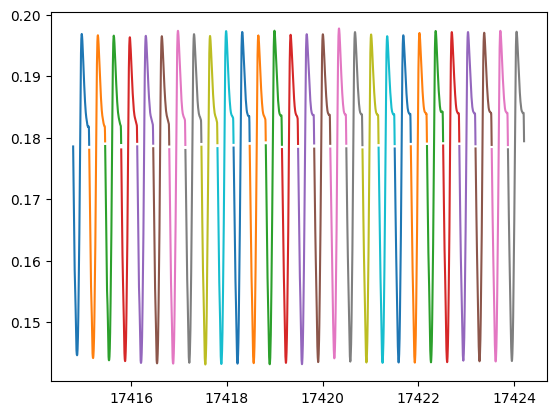

In [255]:
initial_velocity = np.zeros(len(hops))
final_velocity = np.zeros(len(hops))
hop_height = np.zeros(len(hops))
hop_period = np.zeros(len(hops))
for i,hop in enumerate(hops):
    t = hop['t_s'].to_numpy()
    y = hop['y'].to_numpy()
    mode = hop['mode'].to_numpy()
    plt.plot(t,y)
    initial_velocity[i] = (y[1]-y[0])/(t[1]-t[0])
    j = next(j for j, m in enumerate(mode) if m==1)
    final_velocity[i] = (y[j+1]-y[j])/(t[j+1]-t[j])
    hop_height[i] = final_velocity[i]**2 / (2*9.81)
    hop_period[i] = t[-1]-t[0]
print(initial_velocity)
print(final_velocity)
print(hop_height)
print(1/np.average(hop_period))

In [256]:
hop_avg = np.average(hop_height)
hop_std = np.std(hop_height)
print(hop_std)

# filter outliers
outliers = [i for i,h in enumerate(hop_height) if (h-hop_avg)**2 > (3*hop_std)**2]
print(outliers)
# outliers = []
hop_height = np.array([h for i, h in enumerate(hop_height) if i not in outliers])
hop_energy = np.array([E for i,E in enumerate(energy.hop_energy.to_numpy()) if i not in outliers])

0.0035306414029635624
[]


In [257]:
# Calculate the height-normalized energy consumption
normalized_energy = np.average(hop_energy)/np.average(hop_height)
# normalized_energy = np.average(hop_energy/hop_height)
print('Energy Consumption:')
print(f'{normalized_energy:.3f} Joules \\ meter')

Energy Consumption:
41.229 Joules \ meter


0.04671949824623206
0.0035306414029635624


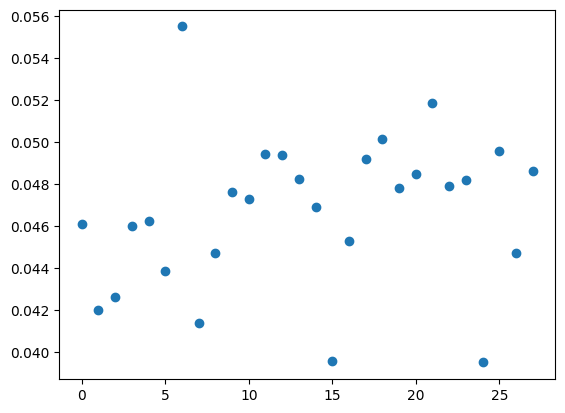

In [258]:
"""
Now that we have indices to liftoff and touchdown, 
we can reorganize the data according to contact mode,
rather than the controller mode (which is how the data was originally saved)
"""
plt.scatter(list(range(len(hop_height))),hop_height)
print(np.average(hop_height))
print(np.std(hop_height))
# plt.scatter(list(range(len(hop_height))),energy.hop_energy/hop_height/100)
# plt.scatter(list(range(len(final_velocity))), final_velocity)

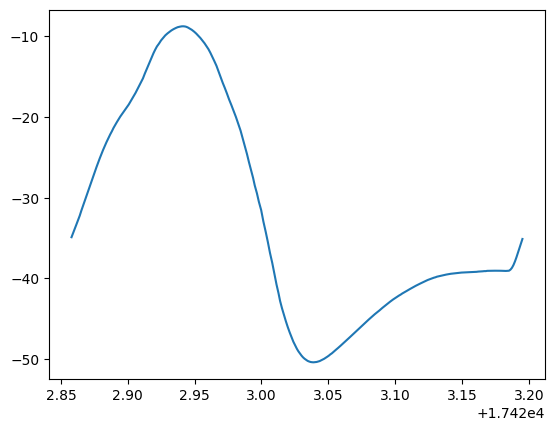

In [259]:
plt.plot(hops[-4]['t_s'],hops[-4]['x_deg'])

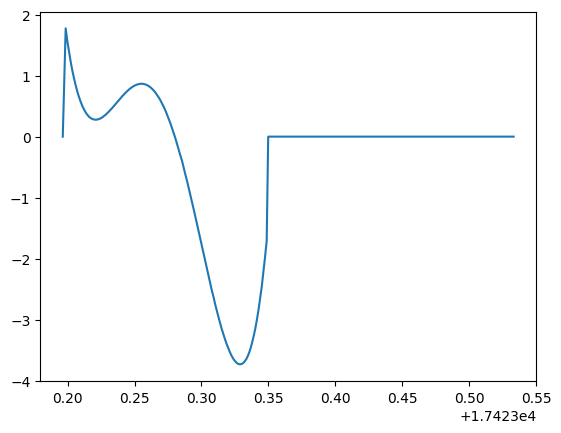

In [260]:
plt.plot(hops[-3]['t_s'],hops[-3]['u_ff'])

0.5456740906007841
0


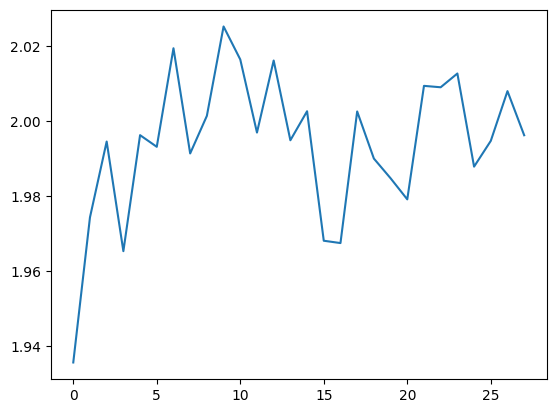

In [261]:
R = .095
Kv = 105*(2*np.pi/60)/6
Kt = 1/Kv
print(Kt)
Kx = experiment_config['controller']['kp'][-1]
x0 = experiment_config['controller']['x0'][-1]
print(Kx)

# compute the stance electrical power
power = np.zeros(len(hops))
for i, hop in enumerate(hops):
    indices = hop['mode'] == 2
    x = hop['x_deg'][indices]*np.pi/180
    t = hop['t_s'][indices]
    # x = hop['x_deg']*np.pi/180
    # t = hop['t_s']
    xdot = np.diff(x)/np.diff(t)
    x = x[1:]
    t = t[1:]
    # tau = hop['torque'][indices][:-1]
    # tau = hop['torque'][:-1]
    tau = hop['u_ff'][indices][1:] + Kx*(x0 - x)
    power[i] = np.trapz(R*(tau/Kt)**2 + tau*xdot, t)
plt.plot(power)

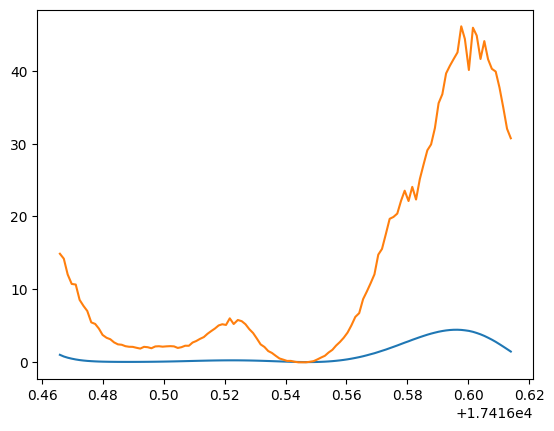

In [262]:
hop = hops[5]
indices = hop['mode'] == 2
x = hop['x_deg'][indices]*np.pi/180
t = hop['t_s'][indices]
# x = hop['x_deg']*np.pi/180
# t = hop['t_s']
xdot = np.diff(x)/np.diff(t)
x = x[1:]
t = t[1:]
# tau = hop['torque'][indices][:-1]
# tau = hop['torque'][:-1]
tau = hop['u_ff'][indices][1:] + Kx*(x0 - x)
# power[i] = np.trapz(R*(tau/Kt)**2 + tau*xdot, t)
plt.plot(t,R*(tau/Kt)**2)
plt.plot(t,tau*xdot)